## Questions
The data was completely collected on 2020-08-05

What are the questions that I want to answer, given the data that I now have?
- How many jobs are remote?
- For jobs with pay range information, what is the average floor for each job category? Ceiling?
- Is there a tendency for a particular job to be remote more than another?
- What are the top 20 jobs that are being sought after?
- When you remove very old posts (30+ days) how much do these figures change?
    - what could be the reason for some of the older jobs hanging out on the job boards?
- What are the top 20 companies really pushing to hire?
- What are the top 20 locations that are hiring? Does it matter?

This could be structured in the typical "who, what, where, when"
- **Who** -> who are the companies that are recruiting the most?
- **What** -> what are the jobs that are most sought after
- **Where** -> what states are hiring the most people (with the understanding that a lot of work is remote, but this could change if restrictions begin to lift)
- **When** -> are there less newer jobs (7 days or newer). Does it matter?

### Extra 
- how many details are included in the job description snippet?
- can we use LDA to extract the most commonly desired topics?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [138]:
jobs = pd.read_csv('indeed_jobs.csv', sep='|')
jobs.head()

,role,company,location,pay,remote,details,job_post_age,search_field
0,Lead Software Engineer - eCommerce,COVETRUS INC,"Birmingham, AL 35203",NaN,0,"Our advanced web tools, client marketing progr...",30+ days ago,Marketing Technologist
1,Associate Director of UAA Student Web Experience,University of Alaska,"Anchorage, AK 99508 (Rogers Park area)",NaN,0,Produces clear documentation for marketing pag...,30+ days ago,Marketing Technologist
2,"Sales Support, Coronary Clinical Specialist - ...",Philips,"Tucson, AZ",NaN,0,Supports marketing related trade shows and ven...,7 days ago,Marketing Technologist
3,Laboratory Operations Manager,Lighthouse Lab Services,"Phoenix, AZ 85016 (Camelback East area)",NaN,0,Work with hospital strategy department and mar...,13 days ago,Marketing Technologist
4,Snr Key Account Technology Engineer I - EPI,ASM,"Phoenix, AZ",NaN,0,Related work experience can include process en...,30+ days ago,Marketing Technologist


In [139]:
jobs.shape

(248009, 8)

### Clean Data

Because I would like to use the job post age to understand the jobs in the context of removal of older jobs postings, I need to turn the column to integers.

In [140]:
jobs.loc[(jobs['job_post_age'] == 'Just posted') |
         (jobs['job_post_age'] == 'Today'), 'job_post_age'] = '0'
jobs['job_post_age'].value_counts()

30+ days ago    120746
0                11208
1 day ago        10348
5 days ago        8358
6 days ago        8175
7 days ago        7431
2 days ago        6931
8 days ago        6734
13 days ago       5377
12 days ago       5324
14 days ago       4949
9 days ago        4550
15 days ago       4525
20 days ago       3879
19 days ago       3871
21 days ago       3856
22 days ago       3591
28 days ago       3404
26 days ago       3229
16 days ago       3195
4 days ago        3090
27 days ago       3069
23 days ago       2996
29 days ago       2942
11 days ago       1797
18 days ago       1376
25 days ago       1126
3 days ago         768
10 days ago        493
17 days ago        371
24 days ago        300
Name: job_post_age, dtype: int64

In [141]:
jobs['job_post_age'] = jobs['job_post_age'].str.replace('[^0-9]', '')
jobs['job_post_age'] = jobs['job_post_age'].astype(int)
jobs.dtypes

role            object
company         object
location        object
pay             object
remote           int64
details         object
job_post_age     int64
search_field    object
dtype: object

Before removing old jobs, what does the distribution of remote and non remote jobs look like? A '1' indicates a remote opportunity.

In [142]:
jobs['remote'] = jobs['remote'].astype(int)

0    0.876198
1    0.123802
Name: remote, dtype: float64


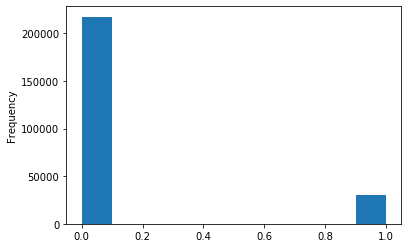

In [143]:
print(jobs['remote'].value_counts(normalize=True))
jobs['remote'].plot.hist();

0    0.840614
1    0.159386
Name: remote, dtype: float64


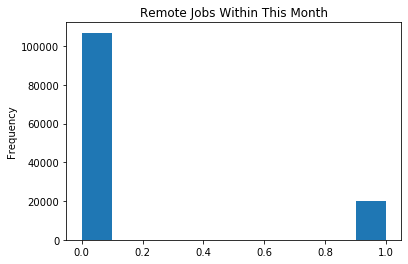

In [144]:
recent_jobs = jobs[jobs['job_post_age'] < 30]
print(recent_jobs['remote'].value_counts(normalize=True))
recent_jobs['remote'].plot.hist(title="Remote Jobs Within This Month");

What about jobs within a week of collection?

0    0.833508
1    0.166492
Name: remote, dtype: float64


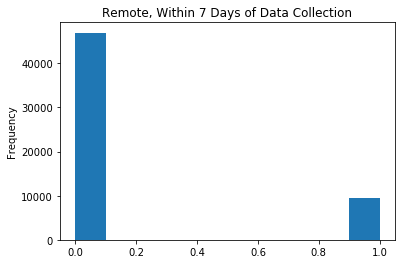

In [145]:
recent_week = jobs[jobs['job_post_age'] <= 7]
print(recent_week['remote'].value_counts(normalize=True))
recent_week['remote'].plot.hist(title="Remote, Within 7 Days of Data Collection");

Roughly the same proportion of job opportunities are marked as remote on Indeed as I progressed from looking at all jobs to jobs posted within a week of data collection. It looks like remote jobs are either still not the norm, or it is not typical yet for a job on indeed to explicitly label itself as a remote possibility. Also, since it's the first time I've looked at this data, I have no means of gauging the change from not-remote to remote job opportunities.

### Pay Range Columns
It would be ideal to create pay range columns for the individual pay ranges ('an hour', 'a month', 'a year'. excluding the smallest groups) in order to create two standardized yearly pay columns like so:

|pay_floor|pay_ceiling|
|---------|-----------|
|50000    |90000      |
|75000    |125345     |

In [146]:
jobs['pay'] = jobs['pay'].fillna('N/A')
jobs.head()

,role,company,location,pay,remote,details,job_post_age,search_field
0,Lead Software Engineer - eCommerce,COVETRUS INC,"Birmingham, AL 35203",N/A,0,"Our advanced web tools, client marketing progr...",30,Marketing Technologist
1,Associate Director of UAA Student Web Experience,University of Alaska,"Anchorage, AK 99508 (Rogers Park area)",N/A,0,Produces clear documentation for marketing pag...,30,Marketing Technologist
2,"Sales Support, Coronary Clinical Specialist - ...",Philips,"Tucson, AZ",N/A,0,Supports marketing related trade shows and ven...,7,Marketing Technologist
3,Laboratory Operations Manager,Lighthouse Lab Services,"Phoenix, AZ 85016 (Camelback East area)",N/A,0,Work with hospital strategy department and mar...,13,Marketing Technologist
4,Snr Key Account Technology Engineer I - EPI,ASM,"Phoenix, AZ",N/A,0,Related work experience can include process en...,30,Marketing Technologist


In [147]:
jobs['pay'] = jobs['pay'].str.replace('$', '')
jobs['pay'] = jobs['pay'].str.replace(',', '')

In order to convert the ranges to floor and ceiling, i need to find out how many different categories of pay range there is (i.e. "a year", "a week", "an hour", etc...)

In [148]:
jobs[jobs['pay'].str.contains('\d+\s\-\s\d+\s(a|an)\s+.*')]['pay'].str.replace('[^a-zA-z]', '').value_counts()

/home/jose/miniconda3/envs/unit2/lib/python3.7/site-packages/pandas/core/strings.py:1952: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


ayear     18128
anhour     7344
amonth      955
aweek        58
aday         27
Name: pay, dtype: int64

For practicality's sake, I'll only convert ranges with "a year", "a month", or "an hour".

In [187]:
jobs['yearly'] = jobs['pay']

In [188]:
# convert anything in the yearly column that isnt yearly to 'N/A'
jobs.loc[~jobs['yearly'].str.contains('a year'), 'yearly'] = 'N/A' 

In [189]:
# remove 'a year' from yearly column
jobs['yearly'] = jobs['yearly'].str.replace('[^0-9\-]', '')
jobs.head()

,role,company,location,pay,remote,details,job_post_age,search_field,yearly,floor_pay_yearly,ceiling_pay_yearly,monthly,hourly
0,Lead Software Engineer - eCommerce,COVETRUS INC,"Birmingham, AL 35203",N/A,0,"Our advanced web tools, client marketing progr...",30,Marketing Technologist,,NaN,NaN,NaN,NaN
1,Associate Director of UAA Student Web Experience,University of Alaska,"Anchorage, AK 99508 (Rogers Park area)",N/A,0,Produces clear documentation for marketing pag...,30,Marketing Technologist,,NaN,NaN,NaN,NaN
2,"Sales Support, Coronary Clinical Specialist - ...",Philips,"Tucson, AZ",N/A,0,Supports marketing related trade shows and ven...,7,Marketing Technologist,,NaN,NaN,NaN,NaN
3,Laboratory Operations Manager,Lighthouse Lab Services,"Phoenix, AZ 85016 (Camelback East area)",N/A,0,Work with hospital strategy department and mar...,13,Marketing Technologist,,NaN,NaN,NaN,NaN
4,Snr Key Account Technology Engineer I - EPI,ASM,"Phoenix, AZ",N/A,0,Related work experience can include process en...,30,Marketing Technologist,,NaN,NaN,NaN,NaN


In [190]:
jobs['floor_pay_yearly'] = jobs['yearly'].str.replace('\-\d+', '')

In [191]:
jobs.loc[jobs['floor_pay_yearly'] == '', 'floor_pay_yearly'] = np.nan

In [192]:
jobs['floor_pay_yearly'] = jobs['floor_pay_yearly'].astype(float)

In [193]:
jobs['ceiling_pay_yearly'] = jobs['yearly'].str.replace('\d+\-', '')
jobs.loc[jobs['ceiling_pay_yearly'] == '', 'ceiling_pay_yearly'] = np.nan
jobs['ceiling_pay_yearly'] = jobs['ceiling_pay_yearly'].astype(float)

In [194]:
jobs['ceiling_pay_yearly'].mean()

96209.16738660907

In [195]:
# repeat the process with monthly pay ranges
jobs['monthly'] = jobs['pay']

# anything in the new column that isn't part of the category becomes 'N/A'
jobs.loc[~jobs['monthly'].str.contains('a month'), 'monthly'] = 'N/A'

# remove 'a month' from column
jobs['monthly'] = jobs['monthly'].str.replace('[^0-9\-]', '')
jobs.loc[jobs['monthly'] == '', 'monthly'] = np.nan

# insert floor and ceiling into the corresponding yearly column
jobs.loc[jobs['monthly'].notnull(), 'floor_pay_yearly'] = (jobs['monthly']
                                                       .str.replace('\-\d+', '')
                                                       .astype(float) * 12)
jobs.loc[jobs['monthly'].notnull(), 'ceiling_pay_yearly'] = (jobs['monthly']
                                                            .str.replace('\d+\-', '')
                                                            .astype(float) * 12)

Here, I'm multiplying hourly rates by 2 and then by 1000. This is operating under the rough assumption that if a person makes 70,000 dollars a year, they are working 40 hours a week for ~52 weeks out of the year:

$(\$35\ per\ hour) \times (40\ hours\ per\ week) \times (52\ weeks) \approx \$70,000\ a\ year$

In [196]:
# repeat the process with hourly pay ranges
jobs['hourly'] = jobs['pay']

# anything in the new column that isn't part of the category becomes 'N/A'
jobs.loc[~jobs['hourly'].str.contains('an hour'), 'hourly'] = 'N/A'

# remove 'an hour' from new column
jobs['hourly'] = jobs['hourly'].str.replace('[^0-9\-\.]', '')
jobs.loc[jobs['hourly'] == '', 'hourly'] = np.nan

# insert floor and ceiling into the corresponding yearly column
jobs.loc[jobs['hourly'].notnull(), 'floor_pay_yearly'] = ((jobs['hourly']
                                                       .str.replace('\-\d+\.*\d*', '')
                                                       .astype(float) * 2) * 1000)
jobs.loc[jobs['hourly'].notnull(), 'ceiling_pay_yearly'] = ((jobs['hourly']
                                                            .str.replace('\d+\.*\d*\-', '')
                                                            .astype(float) * 2) * 1000)

In [209]:
print(f"Average Pay Floor: ${round(jobs['floor_pay_yearly'].mean(), 2)}")
print(f"Average Pay Ceiling: ${round(jobs['ceiling_pay_yearly'].mean(), 2)}")

Average Pay Floor: $68350.78
Average Pay Ceiling: $87192.27
